In [1]:
import os 

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 
import altair as alt

### Process .out file and record values
Values to calculate from: 
- total time
- average run time per iteration 
- variance run time per iteration 
- total cpu run time
- total MPI IO time
- total cuda run time 
- 

In [ ]:
# build result data structure 
# data_path = "./data/slurm-3239966.out"
def process_file(file_path):
    results = []
    with open(file_path, "r") as f:
        for line in f.readlines():
            # check for the experiment logs 
            if line.startswith("|FILEOUT|"):
                # parse the line 
                line_sections = line.split("|")
                log_type = line_sections[2]
                if log_type in ["MPI_IO", "MPI_Allgather", "MPI_Alltoall"]:
                    run_dict = {
                        "algo": log_type,
                        "scaling": line_sections[3],
                        "thread_count": int(line_sections[4].split(" ")[1]),
                        "rank_size": int(line_sections[5].split(" ")[1]),
                        "boids_count": int(line_sections[6].split(" ")[1]),
                        "total_io_cycles": 0,
                        "total_cuda_cycles": 0,
                        "total_comm_cycles": 0,
                        "print_cycles": 0,
                    }
                elif log_type == "MPI":
                    run_dict["total_cycles"] = int(line_sections[-1].split(" ")[-1]) - run_dict['print_cycles']
                    run_dict["total_cpu_cycles"] = run_dict["total_cycles"] - run_dict["total_io_cycles"] - run_dict["total_cuda_cycles"] - run_dict["total_comm_cycles"]
                    results.append(run_dict)
                else: 
                    # ts = line_sections[2].split(" ")[1]
                    run_time = line_sections[-1].split(" ")[-1]
                    if line_sections[2] == "IO_WRITE":
                        run_dict["total_io_cycles"] += int(run_time)
                    elif line_sections[2] == "CUDA":
                        run_dict["total_cuda_cycles"] += int(run_time)
                    elif line_sections[2] == "IO_READ":
                        run_dict["total_io_cycles"] += int(run_time)
                    elif line_sections[2] == "MPI_COMM":
                        run_dict["total_comm_cycles"] += int(run_time)
                    elif line_sections[2] == "PRINT":
                        run_dict["print_cycles"] += int(run_time)

    result_df = pd.DataFrame(results)
    return result_df
            

In [3]:
156673130
229138913

229138913

In [4]:
# go through the data files 
data_path = "./data/"
full_df = pd.DataFrame()
for file_path in os.listdir(data_path):
    if file_path.endswith(".out"):
        result_df = process_file(os.path.join(data_path, file_path))
        full_df = pd.concat([full_df, result_df], ignore_index=True)

full_df['time'] = full_df['total_cycles'] / 1e6
full_df['cpu_time'] = full_df['total_cpu_cycles'] / 1e6
full_df['io_time'] = full_df['total_io_cycles'] / 1e6
full_df['cuda_time'] = full_df['total_cuda_cycles'] / 1e6
full_df['comm_time'] = full_df['total_comm_cycles'] / 1e6

In [5]:
full_df.head()

,algo,scaling,thread_count,rank_size,boids_count,total_io_cycles,total_cuda_cycles,total_comm_cycles,total_cycles,total_cpu_cycles,time,cpu_time,io_time,cuda_time,comm_time
0,MPI_Allgather,STRONG_SCALE,64,1,16,1382046,157068131,70559910,229138913,128826,229.138913,0.128826,1.382046,157.068131,70.559910
1,MPI_Allgather,STRONG_SCALE,64,2,16,528164,232341673,128540942,361541948,131169,361.541948,0.131169,0.528164,232.341673,128.540942
2,MPI_Allgather,STRONG_SCALE,64,4,16,1582491,375831230,186426917,563994243,153605,563.994243,0.153605,1.582491,375.831230,186.426917
3,MPI_Allgather,STRONG_SCALE,128,1,16,1578783,159372549,66529953,227618003,136718,227.618003,0.136718,1.578783,159.372549,66.529953
4,MPI_Allgather,STRONG_SCALE,128,2,16,600478,244957481,126332835,372028057,137263,372.028057,0.137263,0.600478,244.957481,126.332835


In [6]:
# temporary algo type 
# copy1_df = full_df.copy()
# copy1_df['algo'] = "alltoall"

# copy2_df = full_df.copy()
# copy2_df['algo'] = "allgather"

# full_df = pd.concat([full_df, copy1_df, copy2_df], ignore_index=True)
# full_df.head()

In [7]:
full_df.loc[(full_df['scaling'] == 'STRONG_SCALE') & (full_df['boids_count'] == 64) & (full_df['rank_size'] == 4) & (full_df['thread_count'] == 512), :]

,algo,scaling,thread_count,rank_size,boids_count,total_io_cycles,total_cuda_cycles,total_comm_cycles,total_cycles,total_cpu_cycles,time,cpu_time,io_time,cuda_time,comm_time
26,MPI_Allgather,STRONG_SCALE,512,4,64,9957871,381278225,187950649,579339237,152492,579.339237,0.152492,9.957871,381.278225,187.950649
376,MPI_Alltoall,STRONG_SCALE,512,4,64,9862399,403194041,196366081,609547408,124887,609.547408,0.124887,9.862399,403.194041,196.366081
526,MPI_IO,STRONG_SCALE,512,4,64,3569210,362066766,156946151,522766382,184255,522.766382,0.184255,3.569210,362.066766,156.946151


In [8]:
full_df['algo'].unique()

array(['MPI_Allgather', 'MPI_Alltoall', 'MPI_IO'], dtype=object)

In [9]:
full_df["scaling"].unique()

array(['STRONG_SCALE', 'WEAK_SCALE'], dtype=object)

In [10]:
full_df['thread_count'].unique()

array([  64,  128,  256,  512, 1024], dtype=int64)

In [11]:
full_df['rank_size'].unique()

array([ 1,  2,  4,  8, 16], dtype=int64)

In [12]:
full_df["boids_count"].unique()

array([  16,   64,  256, 1024, 4096], dtype=int64)

### Visualize the results

#### Strong scaling 

In [13]:
strong_df = full_df[full_df['scaling']=="STRONG_SCALE"].copy()

##### Isolated boids algorithm variant analysis

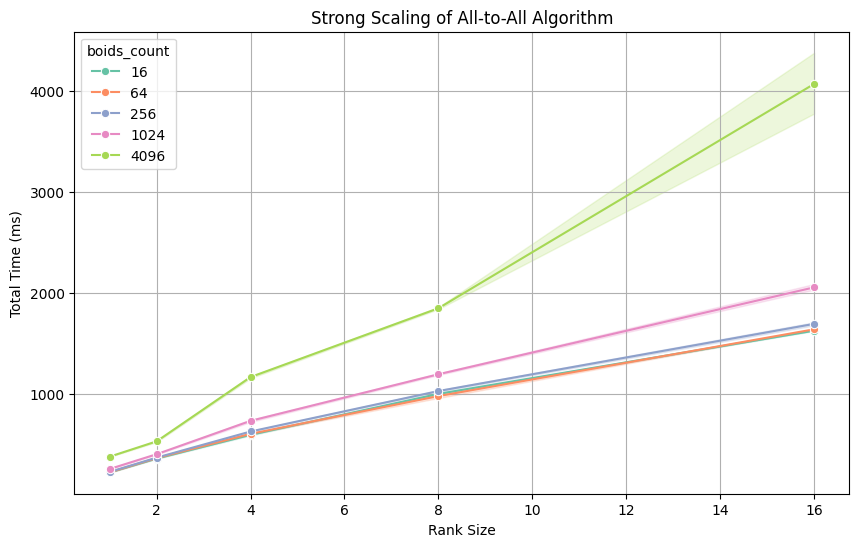

In [14]:
# All-to-All algorithm 

plt.figure(figsize=(10, 6))
sns.lineplot(data=strong_df.loc[strong_df['algo'] == "MPI_Alltoall", :], x='rank_size', y='time', hue='boids_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Strong Scaling of All-to-All Algorithm')
plt.grid(True)
plt.show()

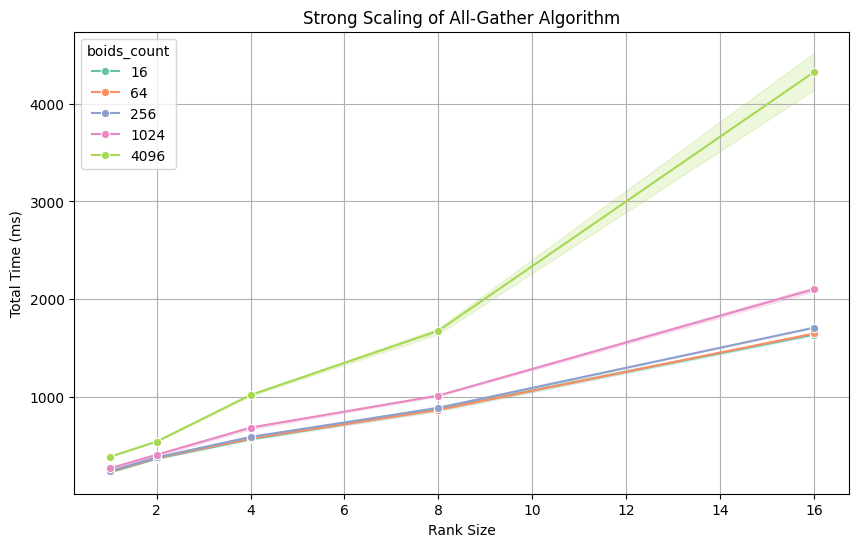

In [15]:
# All-Gather algorithm 

plt.figure(figsize=(10, 6))
sns.lineplot(data=strong_df.loc[full_df['algo'] == "MPI_Allgather", :], x='rank_size', y='time', hue='boids_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Strong Scaling of All-Gather Algorithm')
plt.grid(True)
plt.show()

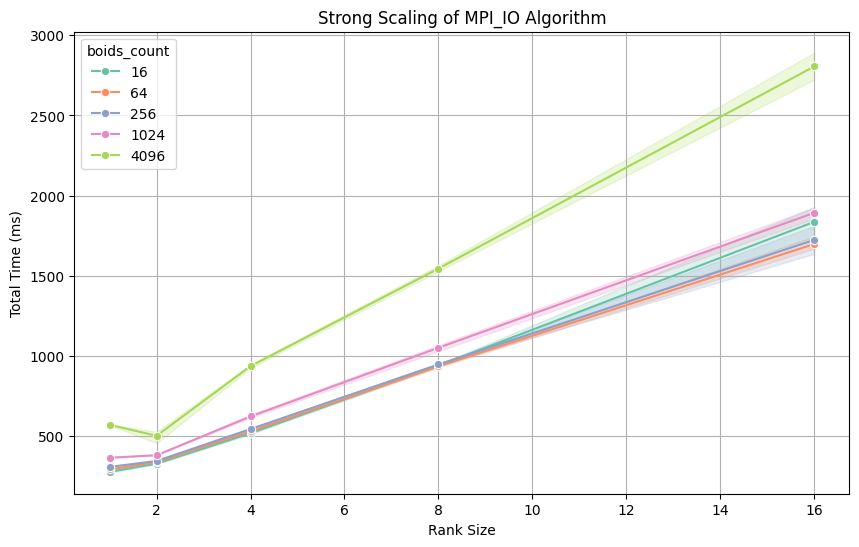

In [16]:
# MPI_IO algorithm 

plt.figure(figsize=(10, 6))
sns.lineplot(data=strong_df.loc[full_df['algo'] == "MPI_IO", :], x='rank_size', y='time', hue='boids_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Strong Scaling of MPI_IO Algorithm')
plt.grid(True)
plt.show()

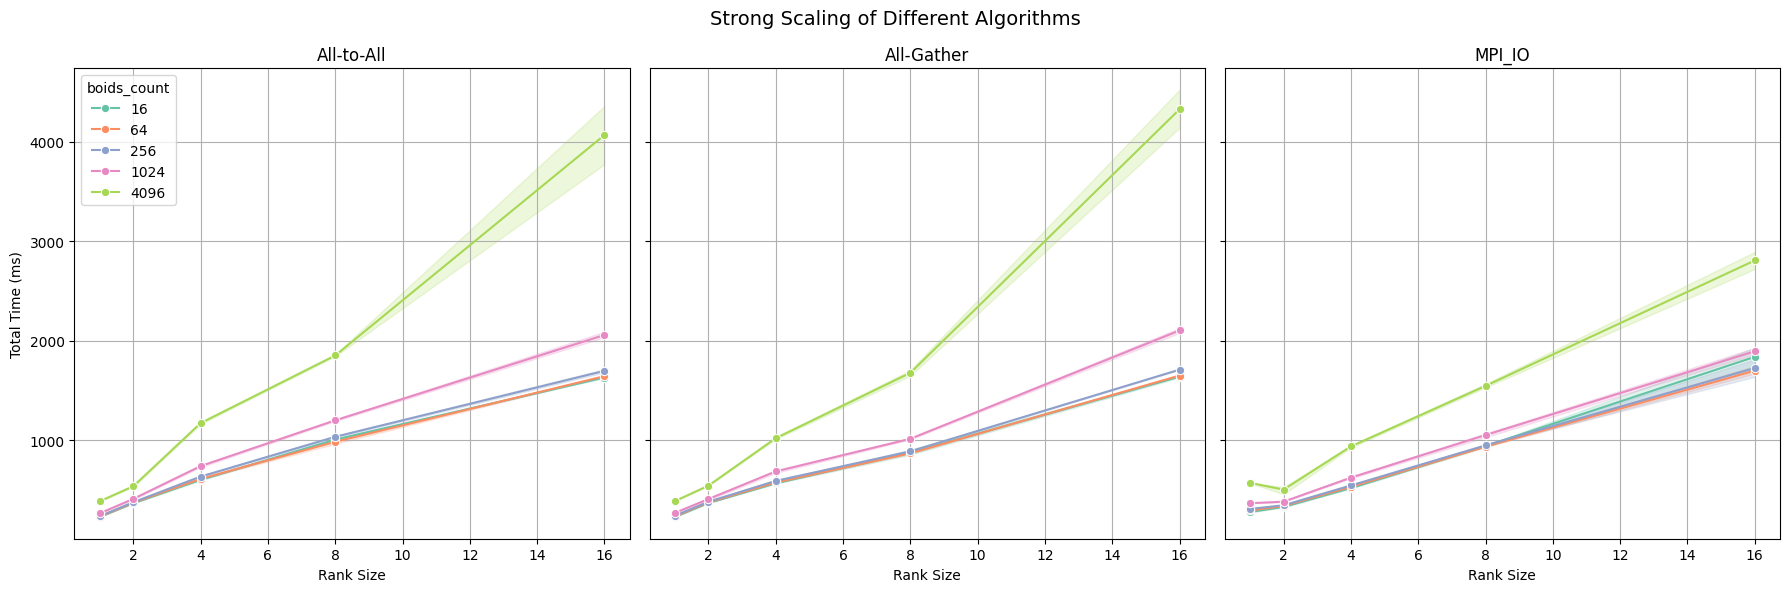

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey for aligned y-axis
palette = "Set2"

# Plot 1: MPI_Alltoall
sns.lineplot(
    data=strong_df.loc[strong_df['algo'] == "MPI_Alltoall", :],
    x='rank_size', y='time', hue='boids_count',
    marker='o', palette=palette, ax=axes[0]
)
axes[0].set_title("All-to-All")
axes[0].set_xlabel("Rank Size")
axes[0].set_ylabel("Total Time (ms)")
axes[0].grid(True)

# Plot 2: MPI_Allgather
sns.lineplot(
    data=strong_df.loc[strong_df['algo'] == "MPI_Allgather", :],
    x='rank_size', y='time', hue='boids_count',
    marker='o', palette=palette, ax=axes[1]
)
axes[1].set_title("All-Gather")
axes[1].set_xlabel("Rank Size")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend_.remove()  # optional to reduce legend clutter

# Plot 3: MPI_IO
sns.lineplot(
    data=strong_df.loc[strong_df['algo'] == "MPI_IO", :],
    x='rank_size', y='time', hue='boids_count',
    marker='o', palette=palette, ax=axes[2]
)
axes[2].set_title("MPI_IO")
axes[2].set_xlabel("Rank Size")
axes[2].set_ylabel("")
axes[2].grid(True)
axes[2].legend_.remove()  # optional

# set title for the entire figure
fig.suptitle("Strong Scaling of Different Algorithms", fontsize=14)  # Adjust y for title spacing
plt.tight_layout()
plt.show()

##### Cross variant analysis

In [18]:
strong_df['boids_count'].unique()

array([  16,   64,  256, 1024, 4096], dtype=int64)

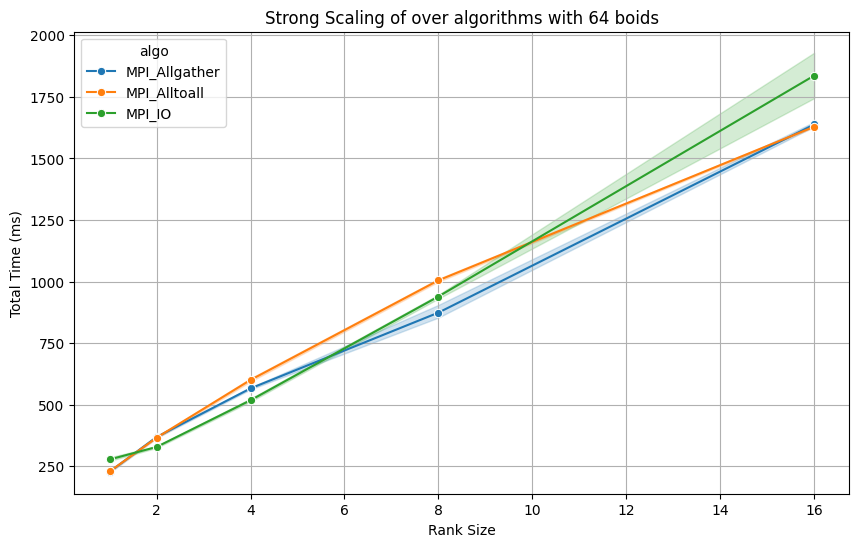

In [19]:
# 64 boids set analysis

plt.figure(figsize=(10, 6))
sns.lineplot(data=strong_df.loc[strong_df['boids_count'] == 16, :], x='rank_size', y='time', hue='algo', marker='o')

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Strong Scaling of over algorithms with 64 boids')
plt.grid(True)
plt.show()

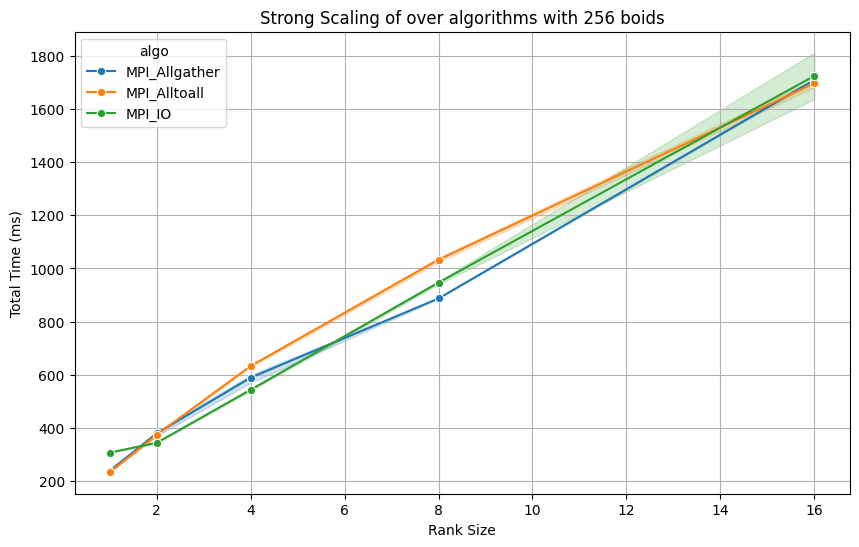

In [20]:
# 256 boids set analysis

plt.figure(figsize=(10, 6))
sns.lineplot(data=strong_df.loc[strong_df['boids_count'] == 256, :], x='rank_size', y='time', hue='algo', marker='o')

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Strong Scaling of over algorithms with 256 boids')
plt.grid(True)
plt.show()

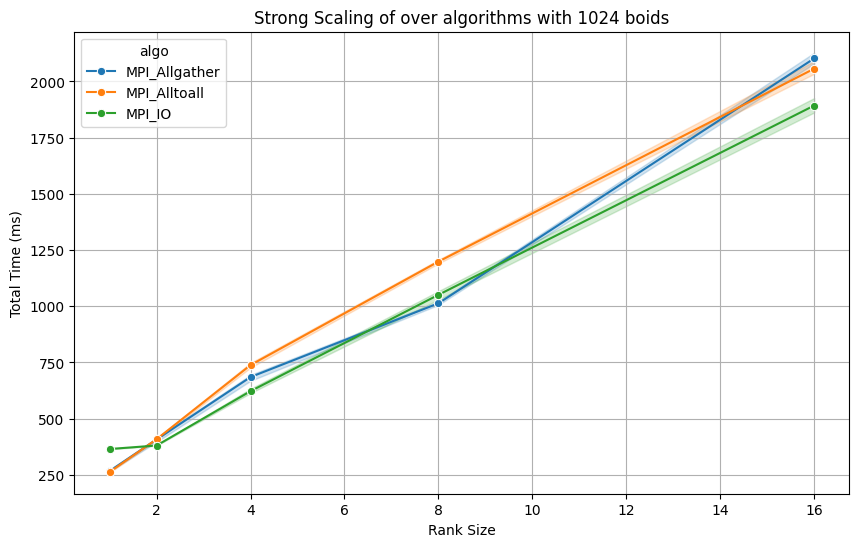

In [21]:
# 1024 boids set analysis

plt.figure(figsize=(10, 6))
sns.lineplot(data=strong_df.loc[strong_df['boids_count'] == 1024, :], x='rank_size', y='time', hue='algo', marker='o')

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Strong Scaling of over algorithms with 1024 boids')
plt.grid(True)
plt.show()

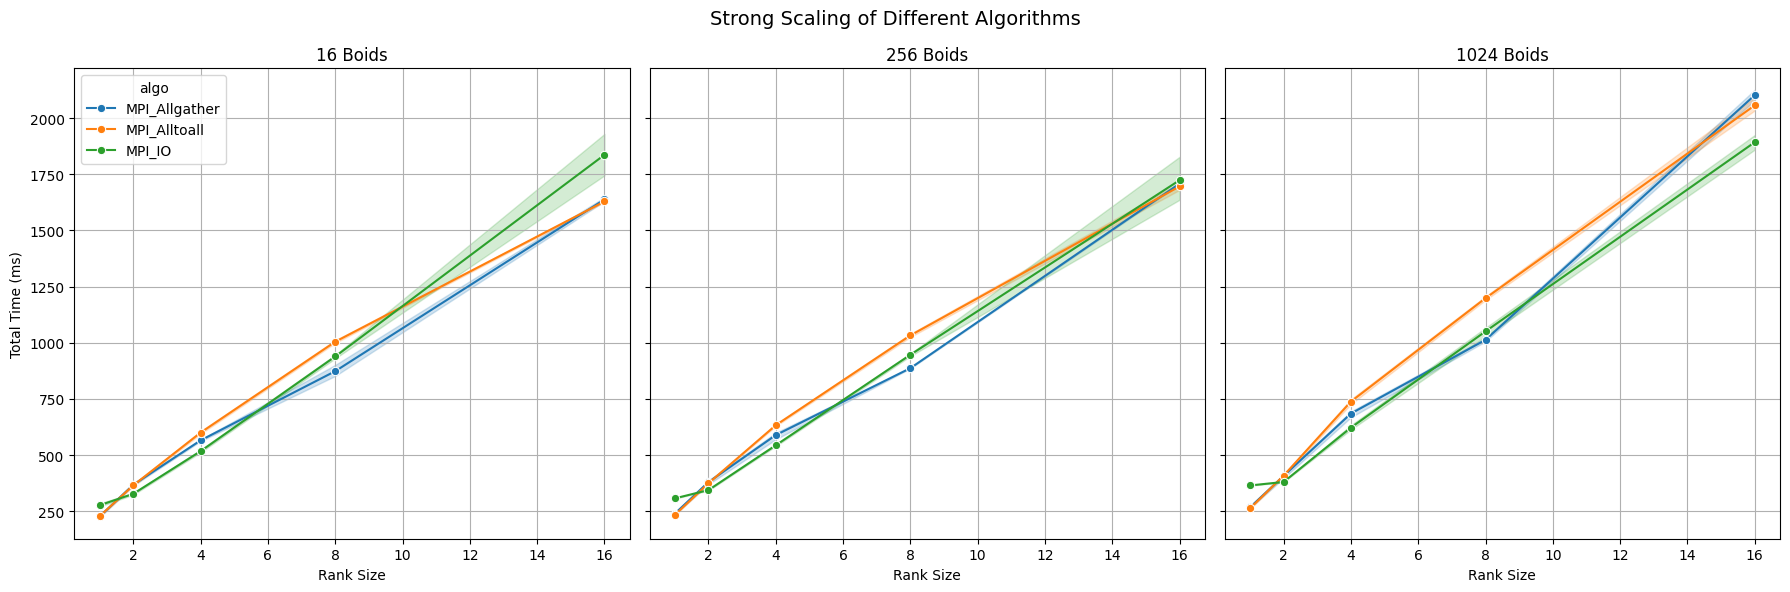

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey for aligned y-axis
palette = "Set2"

sns.lineplot(data=strong_df.loc[strong_df['boids_count'] == 16, :], x='rank_size', y='time', hue='algo', marker='o', ax=axes[0])
axes[0].set_title("16 Boids")
axes[0].set_xlabel("Rank Size")
axes[0].set_ylabel("Total Time (ms)")
axes[0].grid(True)

sns.lineplot(data=strong_df.loc[strong_df['boids_count'] == 256, :], x='rank_size', y='time', hue='algo', marker='o', ax=axes[1])
axes[1].set_title("256 Boids")
axes[1].set_xlabel("Rank Size")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend_.remove()  # optional to reduce legend clutter

sns.lineplot(data=strong_df.loc[strong_df['boids_count'] == 1024, :], x='rank_size', y='time', hue='algo', marker='o', ax=axes[2])
axes[2].set_title("1024 Boids")
axes[2].set_xlabel("Rank Size")
axes[2].set_ylabel("")
axes[2].grid(True)
axes[2].legend_.remove()  # optional

# set title for the entire figure
fig.suptitle("Strong Scaling of Different Algorithms", fontsize=14)  # Adjust y for title spacing
plt.tight_layout()
plt.show()


#### Weak scaling 

In [23]:
weak_df = full_df[full_df['scaling']=="WEAK_SCALE"].copy()

##### Isolated boids algorithm variant analysis

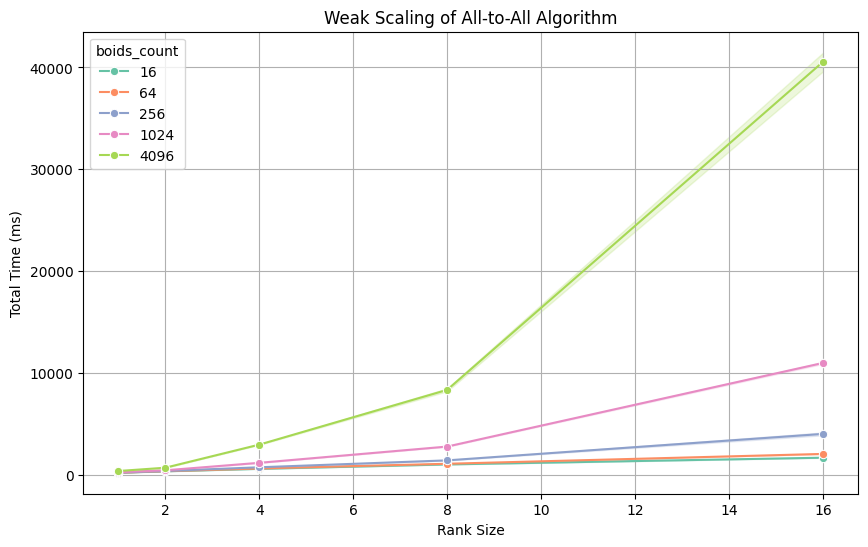

In [24]:
# All-to-ALl algorithm

plt.figure(figsize=(10, 6))
sns.lineplot(data=weak_df.loc[weak_df["algo"] == "MPI_Alltoall", :], x='rank_size', y='time', hue='boids_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Weak Scaling of All-to-All Algorithm')
plt.grid(True)
plt.show()

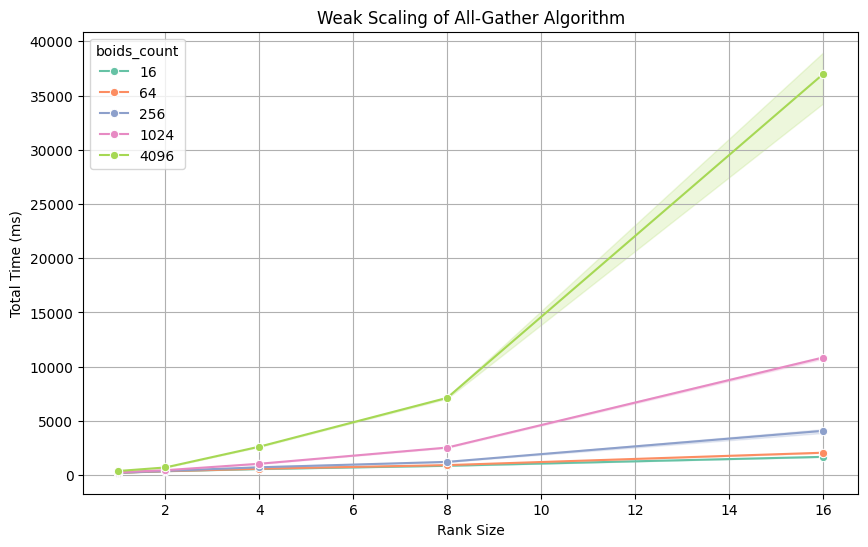

In [25]:
# All-Gather algorithm

plt.figure(figsize=(10, 6))
sns.lineplot(data=weak_df.loc[weak_df["algo"] == "MPI_Allgather", :], x='rank_size', y='time', hue='boids_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Weak Scaling of All-Gather Algorithm')
plt.grid(True)
plt.show()

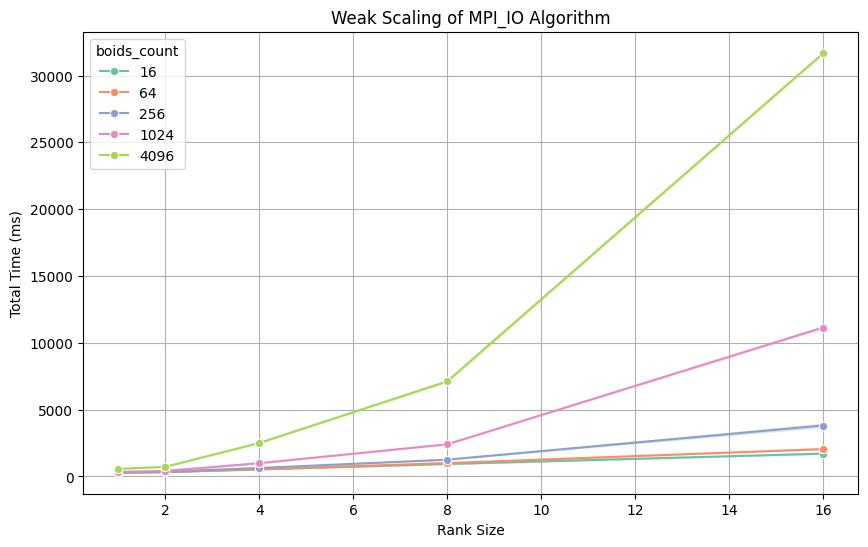

In [26]:
# MPI_IO algorithm

plt.figure(figsize=(10, 6))
sns.lineplot(data=weak_df.loc[weak_df["algo"] == "MPI_IO", :], x='rank_size', y='time', hue='boids_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Weak Scaling of MPI_IO Algorithm')
plt.grid(True)
plt.show()

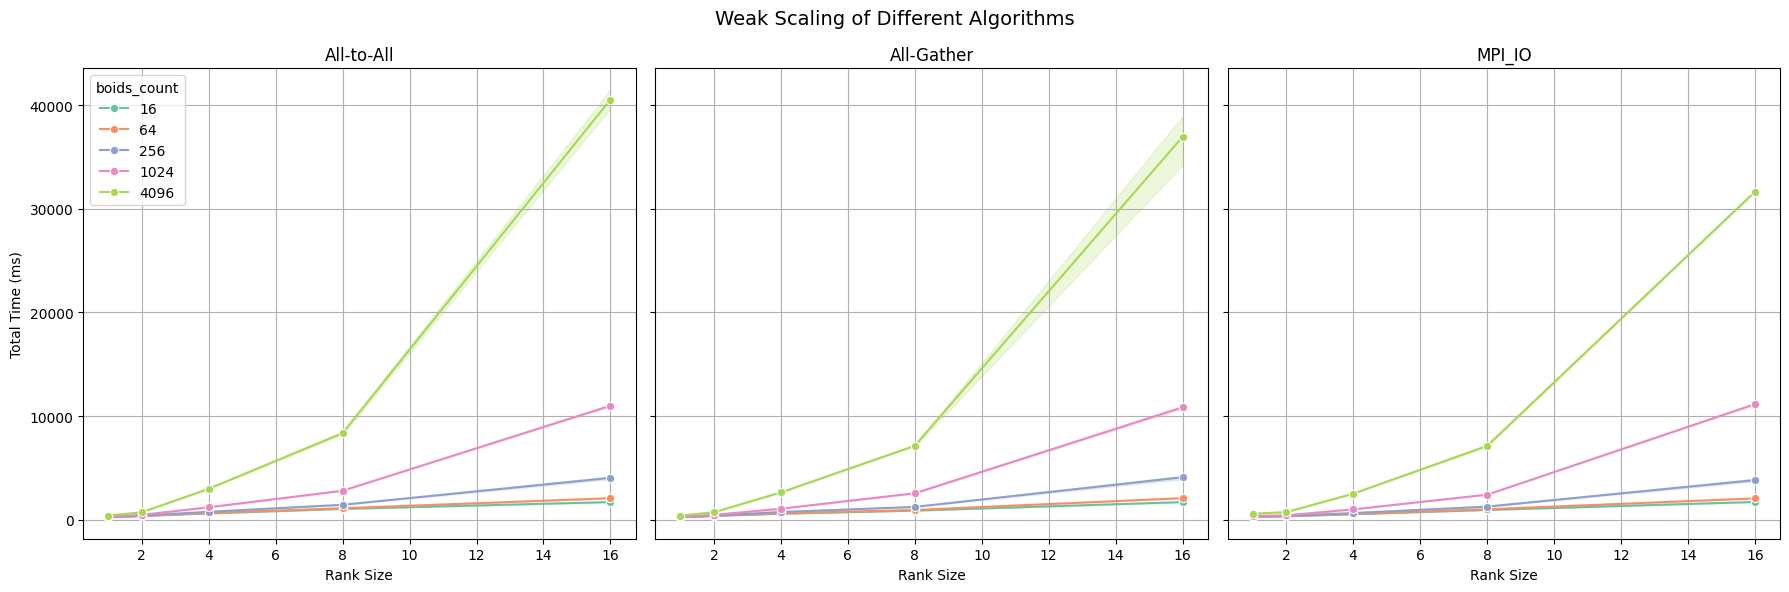

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey for aligned y-axis
palette = "Set2"

# Plot 1: MPI_Alltoall
sns.lineplot(
    data=weak_df.loc[weak_df['algo'] == "MPI_Alltoall", :],
    x='rank_size', y='time', hue='boids_count',
    marker='o', palette=palette, ax=axes[0]
)
axes[0].set_title("All-to-All")
axes[0].set_xlabel("Rank Size")
axes[0].set_ylabel("Total Time (ms)")
axes[0].grid(True)

# Plot 2: MPI_Allgather
sns.lineplot(
    data=weak_df.loc[weak_df['algo'] == "MPI_Allgather", :],
    x='rank_size', y='time', hue='boids_count',
    marker='o', palette=palette, ax=axes[1]
)
axes[1].set_title("All-Gather")
axes[1].set_xlabel("Rank Size")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend_.remove()  # optional to reduce legend clutter

# Plot 3: MPI_IO
sns.lineplot(
    data=weak_df.loc[weak_df['algo'] == "MPI_IO", :],
    x='rank_size', y='time', hue='boids_count',
    marker='o', palette=palette, ax=axes[2]
)
axes[2].set_title("MPI_IO")
axes[2].set_xlabel("Rank Size")
axes[2].set_ylabel("")
axes[2].grid(True)
axes[2].legend_.remove()  # optional

# set title for the entire figure
fig.suptitle("Weak Scaling of Different Algorithms", fontsize=14)  # Adjust y for title spacing
plt.tight_layout()
plt.show()

##### Cross variant analysis

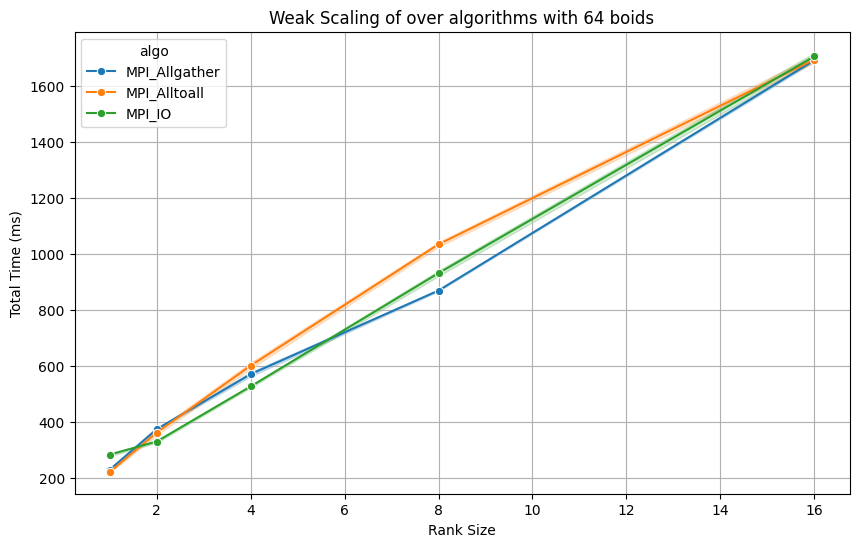

In [28]:
# 64 boids set analysis

plt.figure(figsize=(10, 6))
sns.lineplot(data=weak_df.loc[weak_df['boids_count'] == 16, :], x='rank_size', y='time', hue='algo', marker='o')

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Weak Scaling of over algorithms with 64 boids')
plt.grid(True)
plt.show()

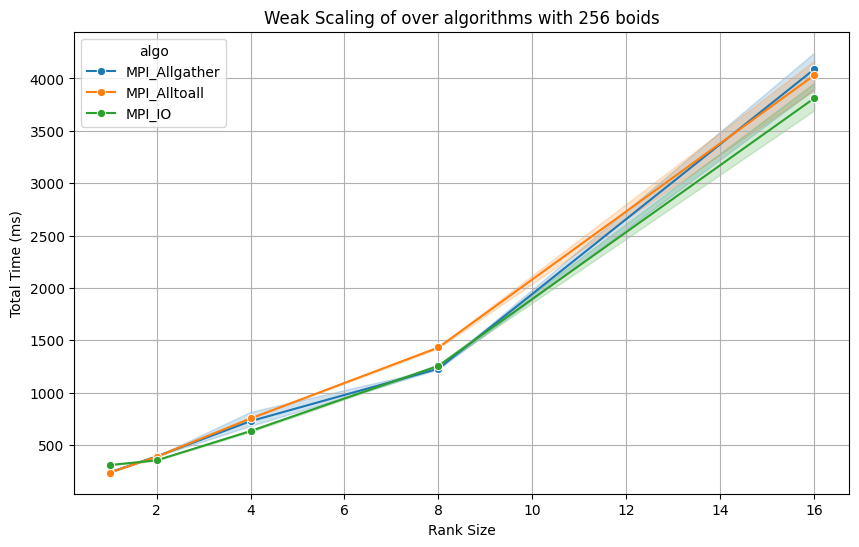

In [29]:
# 256 boids set analysis

plt.figure(figsize=(10, 6))
sns.lineplot(data=weak_df.loc[weak_df['boids_count'] == 256, :], x='rank_size', y='time', hue='algo', marker='o')

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Weak Scaling of over algorithms with 256 boids')
plt.grid(True)
plt.show()

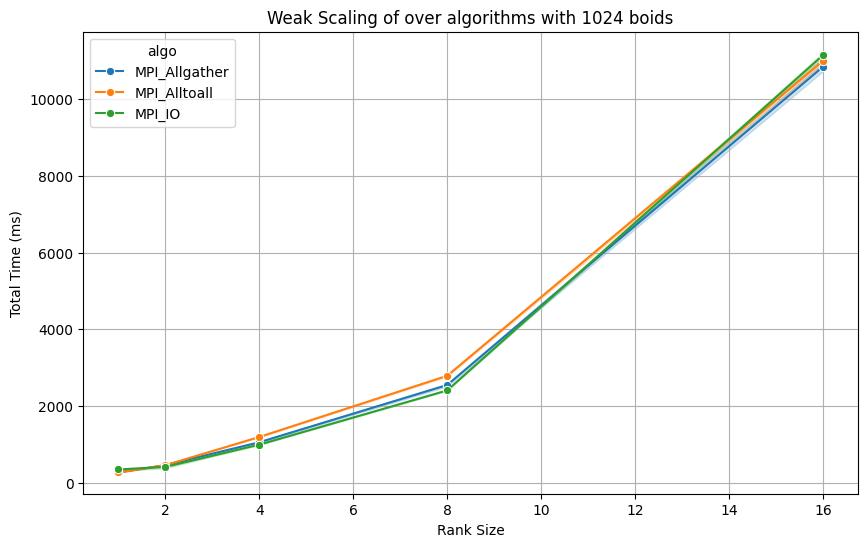

In [30]:
# 1024 boids set analysis

plt.figure(figsize=(10, 6))
sns.lineplot(data=weak_df.loc[weak_df['boids_count'] == 1024, :], x='rank_size', y='time', hue='algo', marker='o')

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Weak Scaling of over algorithms with 1024 boids')
plt.grid(True)
plt.show()

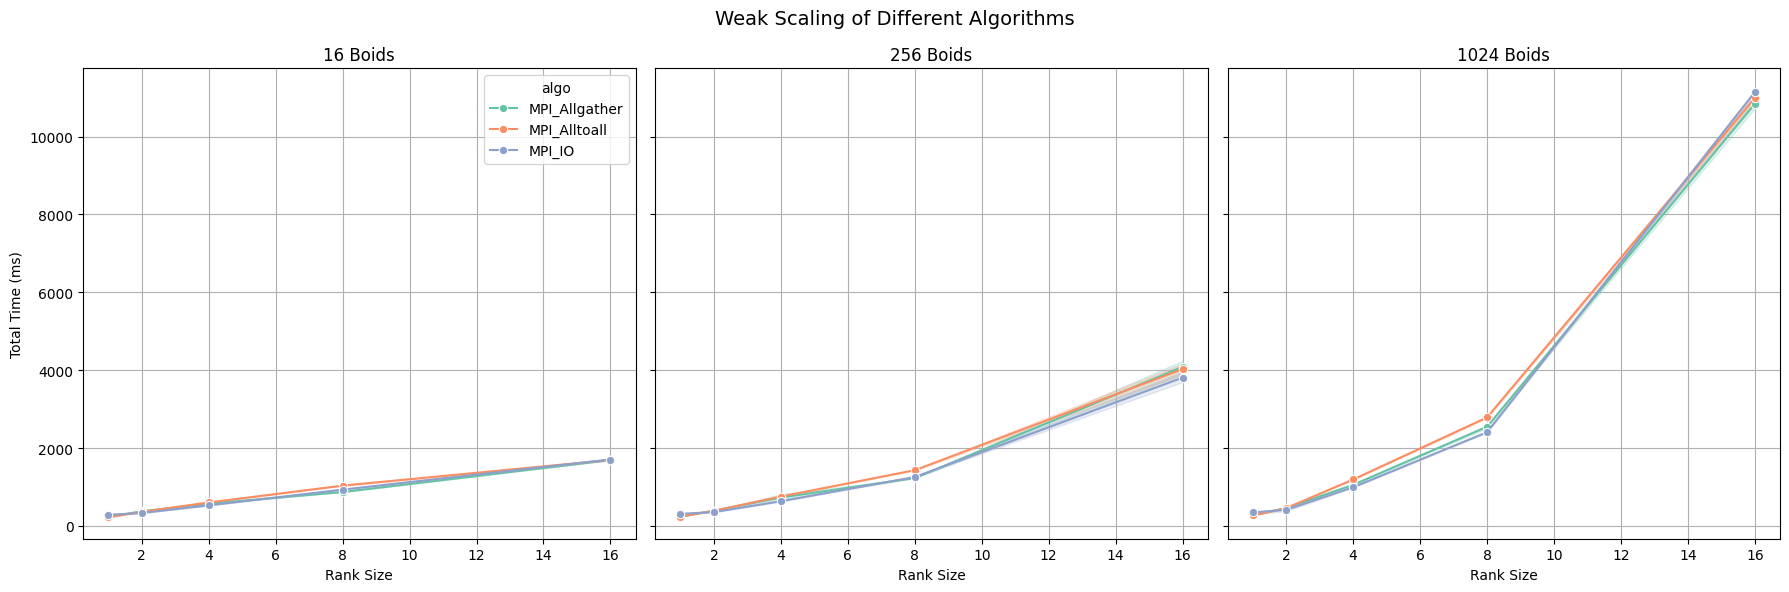

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # sharey for aligned y-axis
palette = "Set2"

# Plot 1: 64 boids
sns.lineplot(
    data=weak_df.loc[weak_df['boids_count'] == 16, :],
    x='rank_size', y='time', hue='algo',
    marker='o', palette=palette, ax=axes[0]
)
axes[0].set_title("16 Boids")
axes[0].set_xlabel("Rank Size")
axes[0].set_ylabel("Total Time (ms)")
axes[0].grid(True)

# Plot 2: 256 boids
sns.lineplot(
    data=weak_df.loc[weak_df['boids_count'] == 256, :],
    x='rank_size', y='time', hue='algo',
    marker='o', palette=palette, ax=axes[1]
)
axes[1].set_title("256 Boids")
axes[1].set_xlabel("Rank Size")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend_.remove()  # optional to reduce legend clutter

# Plot 3: 1024 boids
sns.lineplot(
    data=weak_df.loc[weak_df['boids_count'] == 1024, :],
    x='rank_size', y='time', hue='algo',
    marker='o', palette=palette, ax=axes[2]
)
axes[2].set_title("1024 Boids")
axes[2].set_xlabel("Rank Size")
axes[2].set_ylabel("")
axes[2].grid(True)
axes[2].legend_.remove()  # optional

# set title for the entire figure
fig.suptitle("Weak Scaling of Different Algorithms", fontsize=14)  # Adjust y for title spacing
plt.tight_layout()
plt.show()

#### Strong scaling performance comparison over thread counts

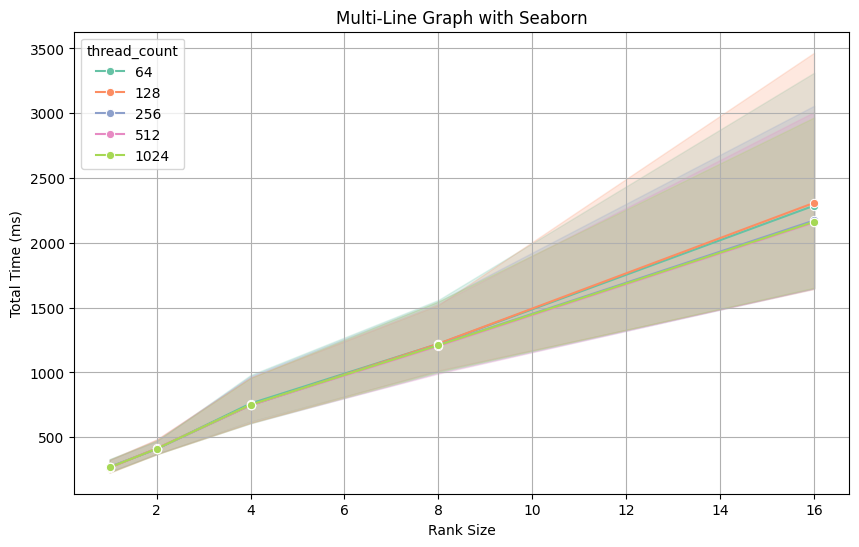

In [32]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=full_df.loc[(full_df['scaling']=="STRONG_SCALE") & (full_df["algo"] == "MPI_Alltoall"), :], x='rank_size', y='time', hue='thread_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Multi-Line Graph with Seaborn')
plt.grid(True)
plt.show()

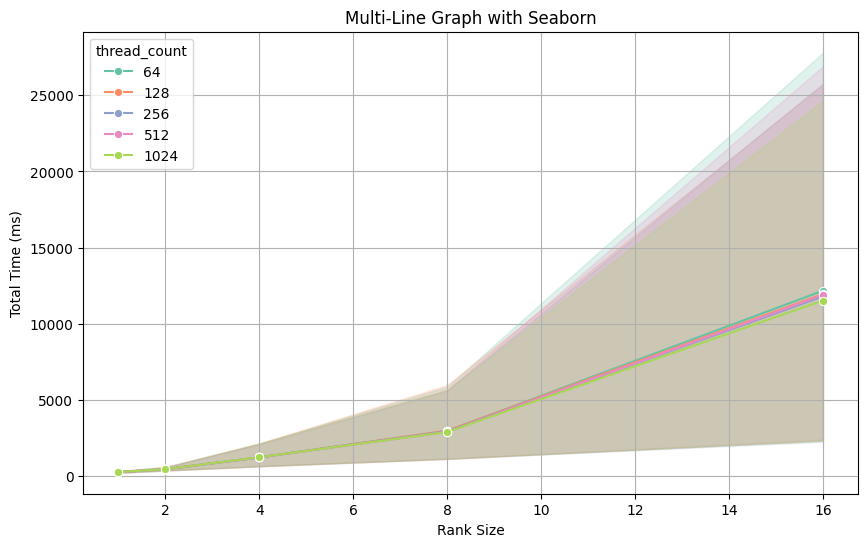

In [33]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=full_df.loc[(full_df['scaling']=="WEAK_SCALE") & (full_df["algo"] == "MPI_Alltoall"), :], x='rank_size', y='time', hue='thread_count', marker='o', palette="Set2")

# Add labels and title
plt.xlabel('Rank Size')
plt.ylabel('Total Time (ms)')
plt.title('Multi-Line Graph with Seaborn')
plt.grid(True)
plt.show()

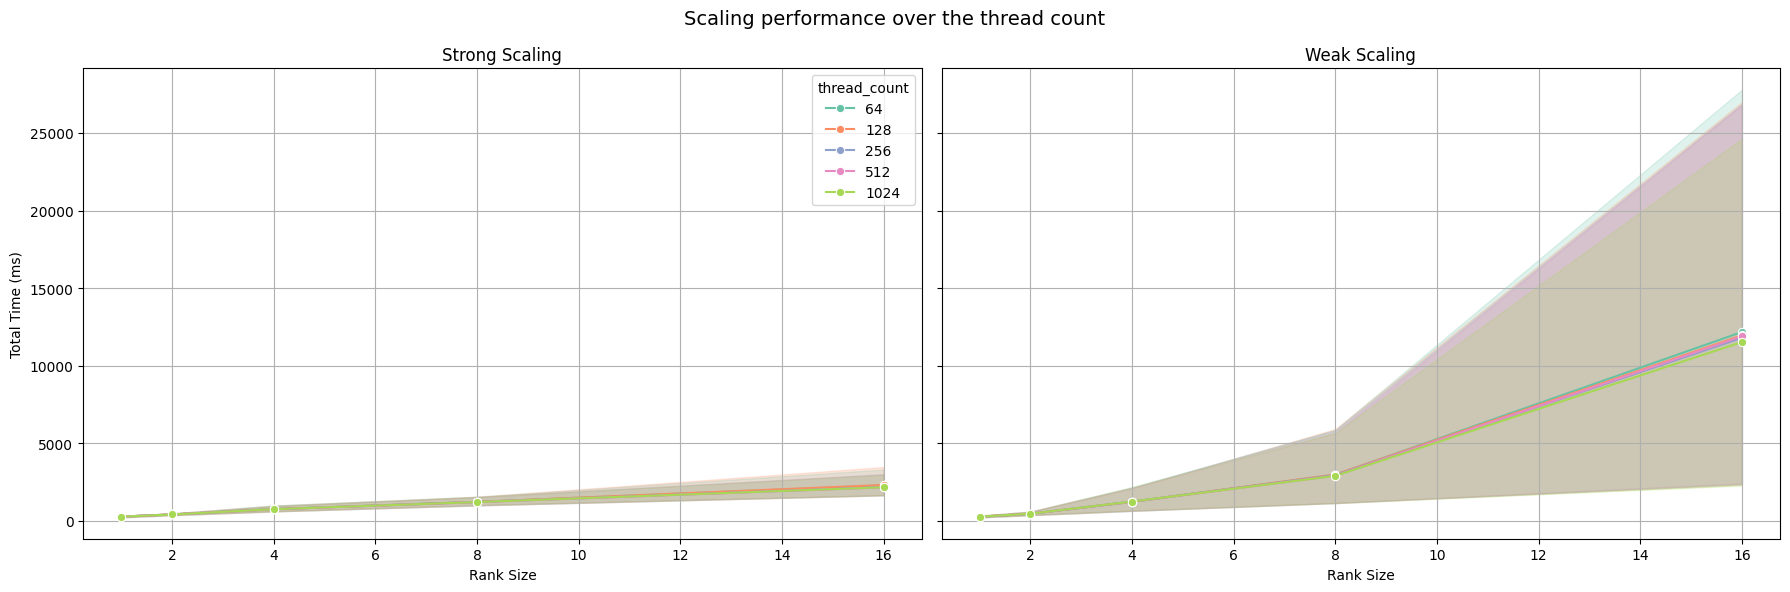

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)  # sharey for aligned y-axis
palette = "Set2"

# Plot 1: Strong Scaling
sns.lineplot(
    data=full_df.loc[(full_df['scaling']=="STRONG_SCALE") & (full_df["algo"] == "MPI_Alltoall"), :],
    x='rank_size', y='time', hue='thread_count',
    marker='o', palette=palette, ax=axes[0]
)
axes[0].set_title("Strong Scaling")
axes[0].set_xlabel("Rank Size")
axes[0].set_ylabel("Total Time (ms)")
axes[0].grid(True)

# Plot 2: Weak Scaling
sns.lineplot(
    data=full_df.loc[(full_df['scaling']=="WEAK_SCALE") & (full_df["algo"] == "MPI_Alltoall"), :],
    x='rank_size', y='time', hue='thread_count',
    marker='o', palette=palette, ax=axes[1]
)
axes[1].set_title("Weak Scaling")
axes[1].set_xlabel("Rank Size")
axes[1].set_ylabel("")
axes[1].grid(True)
axes[1].legend_.remove()  # optional to reduce legend clutter

# set title for the entire figure
fig.suptitle("Scaling performance over the thread count", fontsize=14)  # Adjust y for title spacing
plt.tight_layout()
plt.show()

#### Stacked bar plot show the performance diff. across different algorithms
https://stackoverflow.com/a/47040206/10729303

##### Strong scaling

In [35]:
full_df['boids_count'].unique()

array([  16,   64,  256, 1024, 4096], dtype=int64)

In [46]:
# update full_df for altair
algo1_df = strong_df.loc[(strong_df['algo'] == "MPI_Alltoall") & (strong_df['boids_count'] == 256) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo1_df = algo1_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo1_df['algo'] = "alltoall"

algo2_df = strong_df.loc[(strong_df['algo'] == "MPI_Allgather") & (strong_df['boids_count'] == 256) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo2_df = algo2_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo2_df['algo'] = "allgather"

algo3_df = strong_df.loc[(strong_df['algo'] == "MPI_IO") & (strong_df['boids_count'] == 256) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo3_df = algo3_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo3_df['algo'] = "MPI_IO"


# combine all dataframes
all_df = pd.concat([algo1_df, algo2_df, algo3_df], ignore_index=True)
all_df.head()

,rank_size,time_type,time,algo
0,16,cpu_time,0.131000,alltoall
1,8,cpu_time,0.123053,alltoall
2,1,cpu_time,0.107862,alltoall
3,2,cpu_time,0.127655,alltoall
4,4,cpu_time,0.129905,alltoall


In [47]:
strong_scaling_chart = alt.Chart(all_df).mark_bar().encode(

# tell Altair which field to group columns on
x=alt.X('rank_size:N', title='Rank Size'),

# tell Altair which field to use as Y values and how to calculate
y=alt.Y('sum(time):Q',
    axis=alt.Axis(
        grid=False,
        title='Time (ms)',)),

# tell Altair which field to use to use as the set of columns to be  represented in each group
column=alt.Column('algo:N', title=None),

# tell Altair which field to use for color segmentation 
color=alt.Color('time_type:N',
        scale=alt.Scale(
            # make it look pretty with an enjoyable color pallet
            range=['#69AEFF', '#96ceb4', '#ffcc5c','#ff6f69'],
        ),
    ))\
.configure_view(
    # remove grid lines around column clusters
    strokeOpacity=0    
).properties(
    title = "Time breakdown of different algorithms in strong scaling",
    width=200,   # width of each individual subplot/column
    height=400   # height of each subplot
).configure_view(
    strokeOpacity=0
).configure_title(
    font='Arial',
    fontSize=14,
    anchor='start',
    color='black'
).configure_axis(
    labelFont='Arial',
    labelFontSize=12,
    titleFont='Arial',
    titleFontSize=12
).configure_legend(
    labelFont='Arial',
    labelFontSize=10,
    titleFont='Arial',
    titleFontSize=10
)

strong_scaling_chart

alt.Chart(...)

In [50]:
# update full_df for altair
algo1_df = strong_df.loc[(strong_df['algo'] == "MPI_Alltoall") & (strong_df['boids_count'] == 16) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo1_df = algo1_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo1_df['boids_count'] = 16

algo2_df = strong_df.loc[(strong_df['algo'] == "MPI_Alltoall") & (strong_df['boids_count'] == 256) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo2_df = algo2_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo2_df['boids_count'] = 256

algo3_df = strong_df.loc[(strong_df['algo'] == "MPI_Alltoall") & (strong_df['boids_count'] == 1024) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo3_df = algo3_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo3_df['boids_count'] = 1024

algo4_df = strong_df.loc[(strong_df['algo'] == "MPI_Alltoall") & (strong_df['boids_count'] == 4096) & (strong_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo4_df = algo4_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo4_df['boids_count'] = 4096

# combine all dataframes
all_df = pd.concat([algo1_df, algo2_df, algo3_df, algo4_df], ignore_index=True)
all_df.head()

,rank_size,time_type,time,boids_count
0,16,cpu_time,0.143935,16
1,8,cpu_time,0.127112,16
2,1,cpu_time,0.101357,16
3,2,cpu_time,0.121463,16
4,4,cpu_time,0.120796,16


In [52]:
strong_scaling_chart = alt.Chart(all_df).mark_bar().encode(

# tell Altair which field to group columns on
x=alt.X('rank_size:N', title='Rank Size'),

# tell Altair which field to use as Y values and how to calculate
y=alt.Y('sum(time):Q',
    axis=alt.Axis(
        grid=False,
        title='Time (ms)',)),

# tell Altair which field to use to use as the set of columns to be  represented in each group
column=alt.Column('boids_count:N', title=None),

# tell Altair which field to use for color segmentation 
color=alt.Color('time_type:N',
        scale=alt.Scale(
            # make it look pretty with an enjoyable color pallet
            range=['#69AEFF', '#96ceb4', '#ffcc5c','#ff6f69'],
        ),
    ))\
.configure_view(
    # remove grid lines around column clusters
    strokeOpacity=0    
).properties(
    title = "Time breakdown of different algorithms in strong scaling",
    width=200,   # width of each individual subplot/column
    height=400   # height of each subplot
).configure_view(
    strokeOpacity=0
).configure_title(
    font='Arial',
    fontSize=14,
    anchor='start',
    color='black'
).configure_axis(
    labelFont='Arial',
    labelFontSize=12,
    titleFont='Arial',
    titleFontSize=12
).configure_legend(
    labelFont='Arial',
    labelFontSize=10,
    titleFont='Arial',
    titleFontSize=10
)

strong_scaling_chart

alt.Chart(...)

##### Weak scaling

In [38]:
# update full_df for altair
algo1_df = weak_df.loc[(weak_df['algo'] == "MPI_Alltoall") & (weak_df['boids_count'] == 256) & (weak_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo1_df = algo1_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo1_df['algo'] = "alltoall"

algo2_df = weak_df.loc[(weak_df['algo'] == "MPI_Allgather") & (weak_df['boids_count'] == 256) & (weak_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo2_df = algo2_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo2_df['algo'] = "allgather"

algo3_df = weak_df.loc[(weak_df['algo'] == "MPI_IO") & (weak_df['boids_count'] == 256) & (weak_df['thread_count'] == 512), ['rank_size', 'cpu_time', 'cuda_time', 'io_time', 'comm_time']]
algo3_df = algo3_df.melt(id_vars=['rank_size'], value_vars=['cpu_time', 'cuda_time', 'io_time', 'comm_time'], var_name='time_type', value_name='time')
algo3_df['algo'] = "MPI_IO"


# combine all dataframes
all_df = pd.concat([algo1_df, algo2_df, algo3_df], ignore_index=True)
all_df.head()

,rank_size,time_type,time,algo
0,16,cpu_time,0.145692,alltoall
1,8,cpu_time,0.148839,alltoall
2,1,cpu_time,0.131648,alltoall
3,2,cpu_time,0.129086,alltoall
4,4,cpu_time,0.137072,alltoall


In [39]:
weak_scaling_chart = alt.Chart(all_df).mark_bar().encode(

# tell Altair which field to group columns on
x=alt.X('rank_size:N', title='Rank Size'),

# tell Altair which field to use as Y values and how to calculate
y=alt.Y('sum(time):Q',
    axis=alt.Axis(
        grid=False,
        title='Time (ms)',)),

# tell Altair which field to use to use as the set of columns to be  represented in each group
column=alt.Column('algo:N', title=None),

# tell Altair which field to use for color segmentation 
color=alt.Color('time_type:N',
        scale=alt.Scale(
            # make it look pretty with an enjoyable color pallet
            range=['#69AEFF', '#96ceb4', '#ffcc5c','#ff6f69'],
        ),
    ))\
.configure_view(
    # remove grid lines around column clusters
    strokeOpacity=0    
) .properties(
    title="Time breakdown of different algorithms in weak scaling",
    width=200,   # width of each individual subplot/column
    height=400   # height of each subplot
).configure_view(
    strokeOpacity=0
).configure_title(
    font='Arial',
    fontSize=14,
    anchor='start',
    color='black'
).configure_axis(
    labelFont='Arial',
    labelFontSize=12,
    titleFont='Arial',
    titleFontSize=12
).configure_legend(
    labelFont='Arial',
    labelFontSize=10,
    titleFont='Arial',
    titleFontSize=10
)

weak_scaling_chart

alt.Chart(...)